Starting Hyperparameter Tuning for Random Forest...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Hyperparameter Tuning for Random Forest Complete.
Best Random Forest parameters: {'regressor__max_depth': 20, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200}
Best Random Forest CV score (negative MSE): -6.66

Training Linear Regression...

Training Decision Tree...

Training Random Forest...


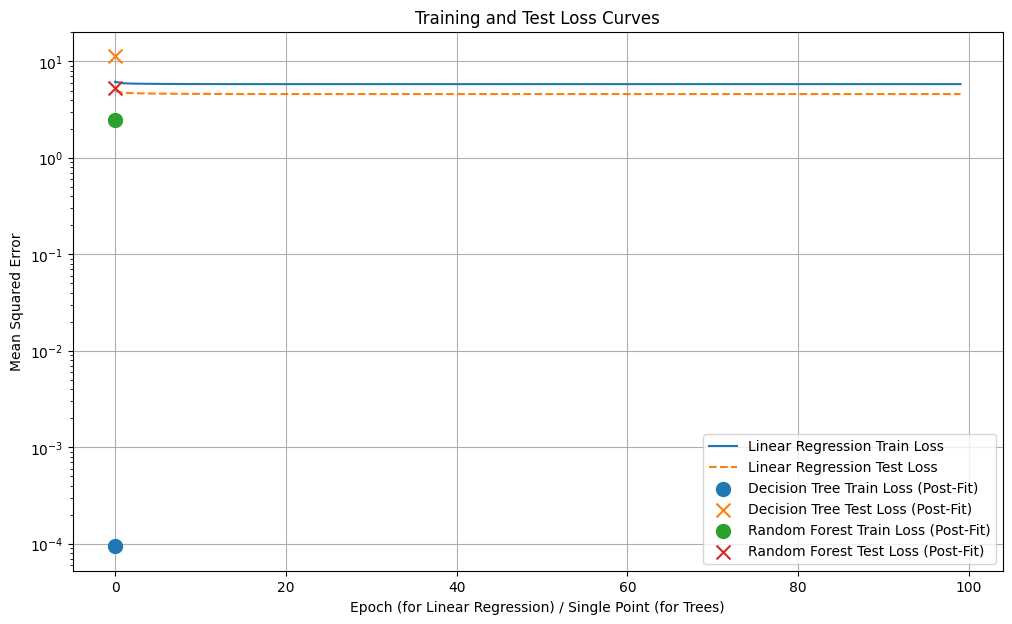

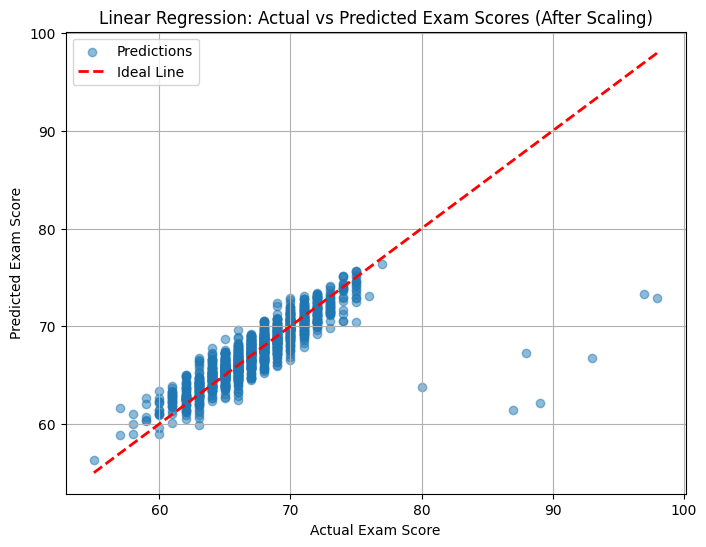


Model Comparison (Modified Code):
Linear Regression:
  MSE: 4.58
  R2: 0.68
  (Best Model)
Decision Tree:
  MSE: 11.34
  R2: 0.20
Random Forest:
  MSE: 5.35
  R2: 0.62

Best model saved to 'best_model_modified.pkl'


In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib

# Load the CSV file
data = pd.read_csv('StudentPerformanceFactors.csv')

# Drop excluded features
excluded_features = ['Family_Income', 'Parental_Involvement', 'Physical_Activity', 'Distance_from_Home',
                     'Motivation_Level', 'Tutoring_Sessions', 'Parental_Education_Level']
data = data.drop(columns=excluded_features)

# Feature constraints for remaining features
feature_constraints = {
    'Hours_Studied': {'type': 'numerical', 'min': 0, 'max': 50},
    'Attendance': {'type': 'numerical', 'min': 0, 'max': 100},
    'Access_to_Resources': {'type': 'categorical', 'values': ['Low', 'Medium', 'High']},
    'Extracurricular_Activities': {'type': 'categorical', 'values': ['Yes', 'No']},
    'Sleep_Hours': {'type': 'numerical', 'min': 0, 'max': 24},
    'Previous_Scores': {'type': 'numerical', 'min': 0, 'max': 100},
    'Internet_Access': {'type': 'categorical', 'values': ['Yes', 'No']},
    'Teacher_Quality': {'type': 'categorical', 'values': ['Low', 'Medium', 'High']},
    'School_Type': {'type': 'categorical', 'values': ['Public', 'Private']},
    'Peer_Influence': {'type': 'categorical', 'values': ['Positive', 'Negative', 'Neutral']},
    'Learning_Disabilities': {'type': 'categorical', 'values': ['Yes', 'No']},
    'Gender': {'type': 'categorical', 'values': ['Male', 'Female']}
}

# Define numerical and categorical columns
numerical_cols = [col for col, spec in feature_constraints.items() if spec['type'] == 'numerical']
categorical_cols = [col for col, spec in feature_constraints.items() if spec['type'] == 'categorical']

# Define preprocessor - MODIFIED to include StandardScaler for numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols), # Added StandardScaler
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Split features and target
X = data.drop('Exam_Score', axis=1)
y = data['Exam_Score']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Linear Regression': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', SGDRegressor(max_iter=1000, tol=1e-3, learning_rate='invscaling', eta0=0.01, random_state=42))
    ]),
    'Decision Tree': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', DecisionTreeRegressor(random_state=42))
    ]),
    'Random Forest': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
    ])
}

# --- Hyperparameter Tuning for Random Forest ---
print("Starting Hyperparameter Tuning for Random Forest...")

# Define the pipeline for Random Forest for GridSearchCV
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Define the parameter grid for Random Forest
param_grid_rf = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [10, 20, None],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2],
}

# Initialize GridSearchCV for Random Forest
grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=3,
                              scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# Fit GridSearchCV for Random Forest
grid_search_rf.fit(X_train, y_train)

# Update the 'Random Forest' model in the dictionary with the best estimator found
models['Random Forest'] = grid_search_rf.best_estimator_

print("Hyperparameter Tuning for Random Forest Complete.")
print(f"Best Random Forest parameters: {grid_search_rf.best_params_}")
print(f"Best Random Forest CV score (negative MSE): {grid_search_rf.best_score_:.2f}")

# --- End Hyperparameter Tuning for Random Forest ---

# Train models and collect performance metrics
results = {}
train_losses = {'Linear Regression': [], 'Decision Tree': [], 'Random Forest': []}
test_losses = {'Linear Regression': [], 'Decision Tree': [], 'Random Forest': []}

for name, model in models.items():
    print(f"\nTraining {name}...")
    if name == 'Linear Regression':
        # --- MODIFIED SECTION FOR LINEAR REGRESSION LOSS PLOTTING ---
        # To correctly plot loss over "epochs" for SGDRegressor within a pipeline,
        # we need to transform the data once and then perform partial_fit on the regressor.
        # Alternatively, we repeatedly fit the full pipeline. The latter is simpler
        # if the number of epochs is not extremely large.
        # For simplicity and correctness with the pipeline, we'll refit the full pipeline
        # multiple times for plotting purposes.
        # For the final model, we fit it fully with max_iter=1000.

        n_epochs_plot = 100 # Number of "epochs" for plotting
        temp_lr_pipeline_for_plot = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', SGDRegressor(max_iter=1, tol=None, warm_start=True, # warm_start to continue training
                                       learning_rate='invscaling', eta0=0.01, random_state=42))
        ])

        # Initial fit to set up the warm_start
        temp_lr_pipeline_for_plot.fit(X_train, y_train)

        for epoch in range(n_epochs_plot):
            # When warm_start=True and max_iter=1, each .fit() call performs one epoch
            temp_lr_pipeline_for_plot.fit(X_train, y_train)
            y_train_pred = temp_lr_pipeline_for_plot.predict(X_train)
            y_test_pred = temp_lr_pipeline_for_plot.predict(X_test)
            train_losses[name].append(mean_squared_error(y_train, y_train_pred))
            test_losses[name].append(mean_squared_error(y_test, y_test_pred))

        # After plotting, ensure the 'models' dictionary holds the fully trained SGDRegressor
        # This will train it with max_iter=1000, tol=1e-3
        model.fit(X_train, y_train)
        # --- END MODIFIED SECTION ---
    else:
        # Train Decision Tree and Random Forest (which is now the tuned one)
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        # For tree models, there's typically only one 'epoch' as they fit once
        train_losses[name].append(mean_squared_error(y_train, y_train_pred))
        test_losses[name].append(mean_squared_error(y_test, y_test_pred))

    # Final performance metrics
    y_test_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)
    results[name] = {'MSE': mse, 'R2': r2, 'model': model}

# Save the best model
best_model_name = min(results, key=lambda x: results[x]['MSE'])
best_model = results[best_model_name]['model']
joblib.dump(best_model, 'best_model_modified.pkl')

# Plot loss curves
plt.figure(figsize=(12, 7))
# Plot for Linear Regression across epochs
if 'Linear Regression' in train_losses and train_losses['Linear Regression']:
    plt.plot(range(len(train_losses['Linear Regression'])), train_losses['Linear Regression'], label='Linear Regression Train Loss')
    plt.plot(range(len(test_losses['Linear Regression'])), test_losses['Linear Regression'], label='Linear Regression Test Loss', linestyle='--')
else:
    print("Linear Regression loss data is empty or not collected for epochs.")

# Plot for Decision Tree and Random Forest (single points)
for name in ['Decision Tree', 'Random Forest']:
    if name in train_losses and train_losses[name]:
        plt.scatter([0], train_losses[name], label=f'{name} Train Loss (Post-Fit)', marker='o', s=100, zorder=5)
        plt.scatter([0], test_losses[name], label=f'{name} Test Loss (Post-Fit)', marker='x', s=100, zorder=5)
    else:
        print(f"{name} loss data is empty or not collected.")

plt.xlabel('Epoch (for Linear Regression) / Single Point (for Trees)')
plt.ylabel('Mean Squared Error')
plt.title('Training and Test Loss Curves')
plt.legend()
plt.grid(True)
plt.yscale('log') # Use log scale for y-axis to better visualize large MSE differences
plt.savefig('loss_curves_modified.png')
plt.show()

# Plot scatter plot for Linear Regression
lr_model = models['Linear Regression']
y_test_pred_lr = lr_model.predict(X_test)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred_lr, alpha=0.5, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Line')
plt.xlabel('Actual Exam Score')
plt.ylabel('Predicted Exam Score')
plt.title('Linear Regression: Actual vs Predicted Exam Scores (After Scaling)')
plt.legend()
plt.grid(True)
plt.savefig('lr_scatter_modified.png')
plt.show()

# Compare models
print("\nModel Comparison (Modified Code):")
for name, metrics in results.items():
    print(f"{name}:")
    print(f"  MSE: {metrics['MSE']:.2f}")
    print(f"  R2: {metrics['R2']:.2f}")
    if name == best_model_name:
        print("  (Best Model)")

print(f"\nBest model saved to 'best_model_modified.pkl'")
